$$f = A*sin(2\pi f + \theta)$$

In [ ]:
# %load classes
from helpers import create_wave_samples, create_audio, plot, get_wave_samples, low_pass
from abc import abstractmethod
from collections.abc import Iterable, Iterator

import numpy as np

class Filter:
  """Abstract base class for filtering spectrum
  """
  @abstractmethod
  def filter(self, hs: np.ndarray, fs:np.ndarray, cutoff: int, factor: float):
    """Filter values
    hs: power values
    fs: frequency values
    cutoff: cutoff frequency
    factor: attenuating factor"""
    raise NotImplementedError("You can't call thid method directly")

class LowpassFilter(Filter):
  """Lowpass filtering
  """
  def filter(self, hs, fs, cutoff: int, factor: float):
    """Low pass filter
    hs: power values
    fs: frequency values
    cutoff: cutoff frequency
    factor: attenuating factor
    """
    return low_pass(hs, fs, cutoff, factor)

class Spectrum:
  """Spectrum class for frequency-domain representation

  hs: power values
  fs: frequency sample
  framerate: sampling frequency
  """
  def __init__(self, hs, fs, framerate):
    self.hs = np.asanyarray(hs)
    self.fs = np.asanyarray(fs)
    self.framerate = framerate
  
  @property
  def amps(self):
      """Get amplitudes"""
      return np.absolute(self.hs)

  def plot(self):
    """Plot spectrum
    """
    plt.plot(self.fs, self.amps)

  def make_wave(self):
    """Create wave from real spectrum
    """
    ys = np.fft.irfft(self.hs)
    ts = np.arange(len(ys)) / self.framerate
    return Wave(ys=ys, ts=ts, framerate=self.framerate)

class Wave:
  """Wave container in time-domain

  ys: amplitude values
  ts: time values
  framerate: sampling rate"""
  def __init__(self, ys, ts, framerate):
    self.ys = ys
    self.__ts = ts
    self.framerate = framerate
  
  @property
  def ts(self):
    """Property accessor to __ts private field
    """
    return self.__ts

  def play(self):
    """Create a listenable wave
    """
    return create_audio(self.ys, self.framerate, autoplay=True)
    
  def plot(self, slice_from=0, slice_to=100):
    """Plot wave
    slice_from: slice samples from (default = 0)
    slice_to: slice samples to (default = 100)
    """
    return plot(self.__ts[slice_from:slice_to], self.ys[slice_from:slice_to], title="Wave in time domain", xlabel="Time", ylabel="Amplitude")
  
  def make_spectrum(self) -> Spectrum:
    """Comput real spectrum
    """
    n = len(self.ys)
    d = 1 / self.framerate

    hs = np.fft.rfft(self.ys)
    fs = np.fft.rfftfreq(n, d)

    return Spectrum(hs, fs, self.framerate)
  
  def make_full_spectrum(self) -> Spectrum:
    """Compute full spectrum
    """
    n = len(self.ys)
    d = 1 / self.framerate

    hs = np.fft.fft(self.ys)
    fs = np.fft.fftfreq(n, d)
    
    hs = np.asanyarray(hs)
    fs = np.asanyarray(fs)
    
    hs = np.fft.fftshift(hs)
    fs = np.fft.fftshift(fs)
    return Spectrum(hs, fs, self.framerate)
  
  def plot_real_fft(self):
    """Plot real spectrum
    """
    spectrum = self.make_spectrum()
    return plot(spectrum.fs, spectrum.amps, title="Wave in the frequency domain (real spectrum)", xlabel="Frequency", ylabel="Power")
    
    
  def plot_full_fft(self):
    """Plot full spectrum
    """
    spectrum = self.make_full_spectrum()
    return plot(spectrum.fs, spectrum.amps, title="Wave in the frequency domain (real spectrum)", xlabel="Frequency", ylabel="Power")

  @property
  def duration(self):
      """Duration (property).
      returns: float duration in seconds
      """
      return len(self.ys) / self.framerate

class Signal:
  """Signal base class
  freq: frequency (default=400)
  amp: amplitude (default=1)
  offset: phase (default=0)
  periodic_function: periodic function (default: np.sin)
  """
  def __init__(self, freq=400, amp=1.0, offset=0, periodic_function=np.sin):
      self.freq = freq
      self.amp = amp
      self.offset = offset
      self.periodic_function = periodic_function

  def print_period(self):
    """Print signal period
    """
    print("Period (s): %f" %(1.0/self.freq))

  
  def create_wave(self, duration=2, framerate=3000):
    """Create Wave instance based on duration and framerate
    duration: wave duration
    framerate: sampling rate (>3000 required)
    """
    ys, ts = create_wave_samples(duration, framerate, self.freq, self.amp, periodic_function=self.periodic_function)
    return Wave(ys, ts, framerate=framerate)

class Modulator:
  """Abstract base class for modulator
  """
  @abstractmethod
  def modulate(self, signal_wave: Wave, carrier_wave: Wave):
    """Modulate signal with a carrier

    signal_wave: the signal wave
    carrier_wave: the carrier wave
    """
    raise NotImplementedError("You need to implement this method before calling it")
  
  @abstractmethod
  def demodulate(self, demodulated_wave: Wave, carrier_wave: Wave):
    """Demodulate modulated signal

    demodulated_wave: the signal wave
    carrier_wave: the carrier wave
    """
    raise NotImplementedError("You need to implement this method before calling it")
    
class AMModulator(Modulator):
  """Amplitude Modulator
  """
  @abstractmethod
  def modulate(self, signal_wave: Wave, carrier_wave: Wave):
    return signal_wave * carrier_wave
  
  @abstractmethod
  def demodulate(self, modulated_wave: Wave, carrier_wave: Wave):
    return modulated_wave * carrier_wave

class WaveWithMul(Wave):
  """Augmented wave with multiplication feature
  """
  @staticmethod
  def convert(wave: Wave):
    """Convert simple Wave to this class instance
    """
    return WaveWithMul(wave.ys, wave.ts, wave.framerate)

  def __mul__(self, other):
    """Multiply waves

    other: the other wave
    """
    return WaveWithMul(self.ys*other.ys, self.ts, self.framerate)

class SequentialIterator(Iterator):
  """Iterate the iterable in sequential order
  _position: the iteration starting position (default=0)
  """

  _position = 0

  def __init__(self, collection) -> None:
    self._collection = collection
  
  
  def __next__(self):
    """Get the next element. 
    Raise an error if the iterable has been whole-looped
    """
    try:
      value = self._collection[self._position]
      self._position += 1
      return value
    except IndexError:
      raise StopIteration()

class WaveSampleCollection(Iterable):
  """Add iteration logic to some iterable
  _collection: the collection to be iterated
  """
  def __init__(self, collection: np.ndarray) -> None:
        self._collection = collection
  
  """Default iterator
  """
  def __iter__(self):
    return SequentialIterator(self._collection)


class SinWaveformBasedSignal(Signal):

  function = np.sin

  def __init__(self, *args, **kwargs):
    super().__init__(*args, **kwargs)
  

  def create_wave(self, duration=2, framerate=3000):
    ys, ts = create_wave_samples(duration, framerate, self.freq, self.amp, periodic_function=self.function)
    self.ys = ys
    self.ts = ts
    return Wave(ys, ts, framerate=framerate)


In [9]:
from helpers import create_wave_samples, plot

In [32]:
class Wave:
    def __init__(self, ys, ts, framerate):
        self.ys = ys
        self.ts = ts
        self.framerate = framerate
    
    def plot(self, slice_from = 0, slice_to=100):
        return plot(self.ys, self.ts, slice_from = slice_from, slice_to = slice_to)

In [36]:
#Define class and attributes
class Signal:
    
    def __init__(self, amplitude = 1.0, frequency = 440, offset = 0, function = np.sin):
        self.amplitude = amplitude
        self.frequency = frequency
        self.offset = offset
        self.function = function
        
    def print_period(self):
        print(f'Period is {self.frequency}')
        #print(f'Ys size is {self.ys}')
    
    def create_wave(self, duration = 2, framerate = 3000):
        ys, ts = create_wave_samples(duration, framerate, self.frequency, self.amplitude)
        #self.ys = ys
        #self.ts = ts
        return Wave(ys, ts, framerate = framerate)
    
#     def plot(self):
#         return plot(self.ts[0:100], self.ys[0:100])

In [37]:
Signal(1.0, 600, 0).create_wave()

In [38]:
signal = Signal(2.0)
wave = signal.create_wave()
signal.print_period()

Period is 440


<ufunc 'sin'>

In [45]:
import numpy as np
class SinWaveFromBasedSignal(Signal):
    function = np.sin
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    
    def create_wave(self, duration=2, framerate=3000):
        ys, ts = create_wave_samples(duration, framerate, self.freq, self.amp, periodic_function = self.function)
        self.ys = ys
        self.ts = ts
        return Wave(ts, ys, framerate=framerate)

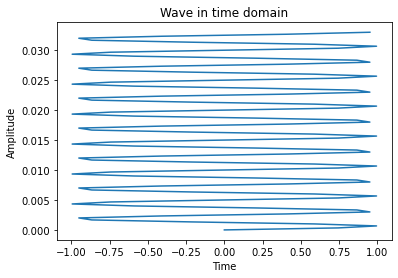

In [46]:
SinWaveFromBasedSignal().create_wave().plot()